In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

def transform_url(url: str):
    import requests, io
    
    return io.StringIO(requests.get(url).content.decode('utf-8'))

base_url = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/'
url_hackathon_scouting = f'{base_url}hackathon_scouting.csv'
url_hackathon_nwhl = f'{base_url}hackathon_nwhl.csv'
url_hackathon_womens = f'{base_url}hackathon_womens.csv'
    
scouting = pd.read_csv(transform_url(url_hackathon_scouting))
nwhl = pd.read_csv(transform_url(url_hackathon_nwhl))
womens = pd.read_csv(transform_url(url_hackathon_womens))

# Data

## Events
Based on the event type, other columns will have a different meaning. X, Y, Player, Player2, and Details columns will differ for each unique value in Event column.

**Notes**: 
- Blank entry in Player 2 means there have no assist.
- Blank in any ``Detail 1`` and ``Detail 2`` column indicates that there are no relevant detail for that specific entry. Should be imputed with a string like: 'None'.
- Blank entry in ``Detail 3`` and ``Detail 4`` column indicates that this column is irrelevant for the given event. Imputation should be an intefer other than 0 or 1. Which can be -1.
- Before Imputing we should take into account that, for any given analysis, data will be fragmented based on the entry at Event column.

In [6]:
# Binarizing Column "Detail 3" and 'Detail 4"
scouting['Detail 3'].replace({'t': 1, 'f': 0}, inplace=True)
scouting['Detail 4'].replace({'t': 1, 'f': 0}, inplace=True)

### Shot: Unsuccesful shot attempts
- Player: Shooter
- Player 2: Passer
- X,Y: Release Location
- Detail 1: Indicates Shot type
- Deatil 2: Shot Destiation which will on net, missed, or blocked
- Detail 3: Traffic, Binary either True or False
- Detail 4: One time, Binary either True or false

# Questions:
1. How does X and Y coordinate affect the shots? 

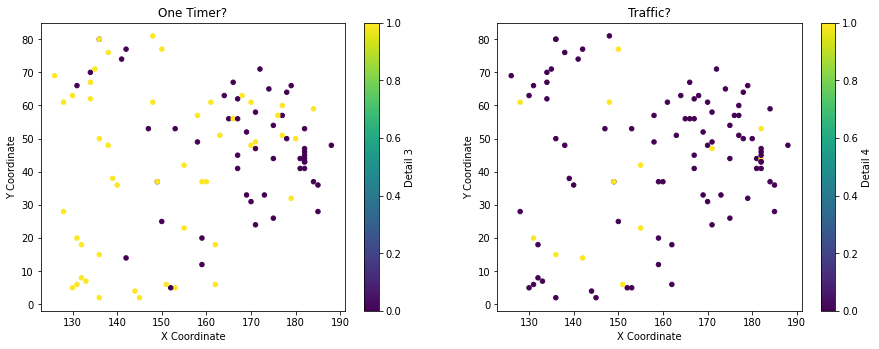

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.tight_layout()

scouting[scouting["Event"] == "Shot"].iloc[:100,].plot(x='X Coordinate', y='Y Coordinate', kind='scatter', c="Detail 3", colormap='viridis', ax=axes[0], title="One Timer?")
scouting[scouting["Event"] == "Shot"].iloc[:100,].plot(x='X Coordinate', y='Y Coordinate', kind='scatter', c="Detail 4", colormap='viridis', ax=axes[1], title="Traffic?")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

2. What is the failure types for different coordinate ranges?
    - Closer to the net, there are more on net shots.
    - 

<AxesSubplot:title={'center':'Missed Type'}, xlabel='X Coordinate', ylabel='Y Coordinate'>

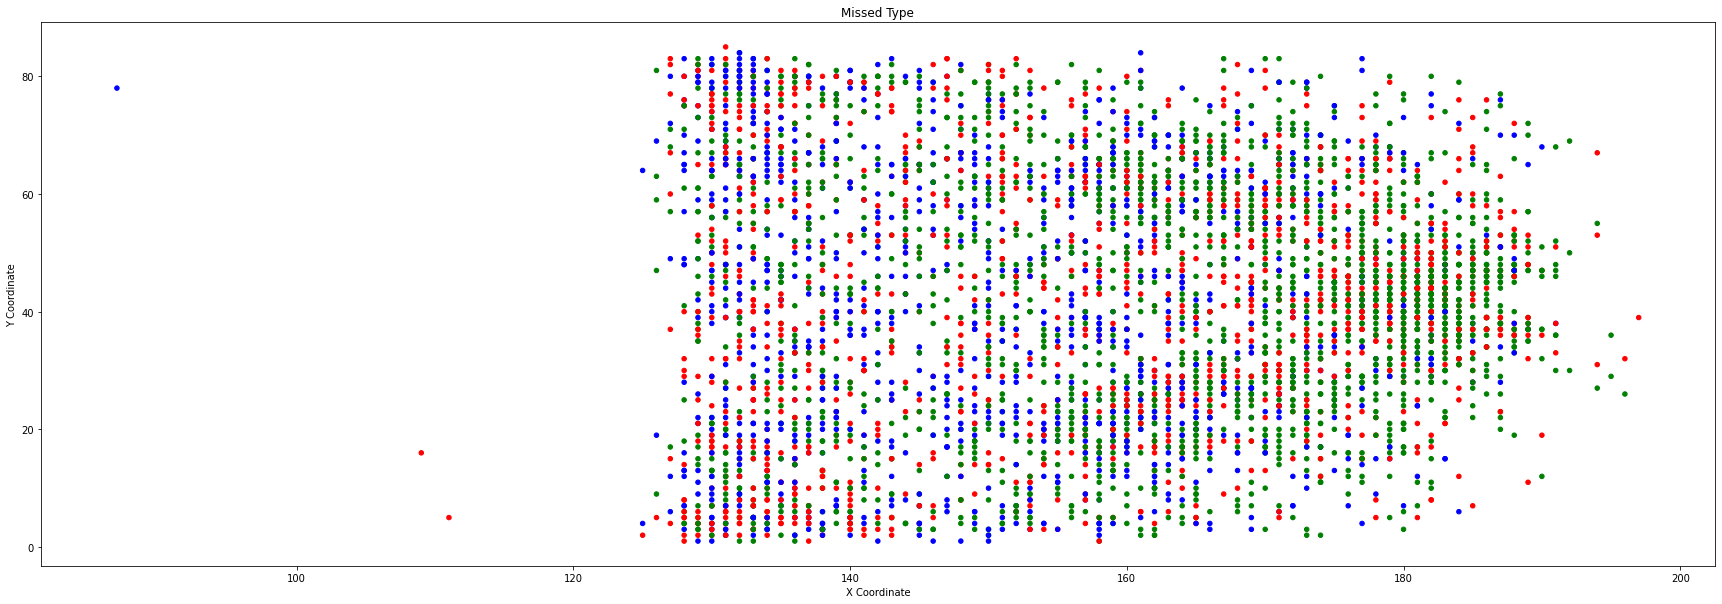

In [63]:
c_map = scouting[scouting["Event"] == "Shot"]['Detail 2'].map({"On Net": "green", "Missed": "red", "Blocked": "blue"}).values

scouting.loc[scouting["Event"] == "Shot", ["X Coordinate", "Y Coordinate", "Detail 2"]].plot.scatter(
    x='X Coordinate', 
    y='Y Coordinate', 
    c=c_map, 
    figsize=(30,10),
    title="Missed Type")

In [65]:
scouting.loc[scouting["Event"] == "Shot", ["X Coordinate", "Y Coordinate", "Detail 2"]].groupby('Detail 2').describe()

X Coordinate                                                     \
                count        mean        std    min    25%    50%    75%   
Detail 2                                                                   
Blocked        1213.0  152.261336  16.242138   87.0  137.0  153.0  164.0   
Missed         1405.0  158.348043  18.667216  109.0  140.0  161.0  175.0   
On Net         2269.0  163.298810  17.423218  126.0  150.0  166.0  178.0   

                Y Coordinate                                               \
            max        count       mean        std  min   25%   50%   75%   
Detail 2                                                                    
Blocked   191.0       1213.0  41.782358  22.946281  1.0  22.0  41.0  63.0   
Missed    197.0       1405.0  41.466904  21.063087  1.0  25.0  42.0  58.0   
On Net    196.0       2269.0  42.167915  19.810511  1.0  27.0  43.0  57.0   

                
           max  
Detail 2        
Blocked   84.0  
Missed    85.0  
On Net    83.0

3. How Shot type (Detail 1) correlates to Shot Destination (Detail 2)? And How does distance (equivalently coordinate) correlate to that?



### Goal: Successfull shot attempts

- Player: Shooter
- Player 2: Passer (blank for unassisted shots)
- X,Y Coordinate: Release location of the puck
- Detail 1: Shot Type (Deflection, Fan, Slapshot, Snapshot, Wrap around, Wristshot)
- Detail 2: Shot destination (on net, missed or blocked)
- Detail 3: Traffic (true or false)
- Detail 4: One timer (true or false)

### Play: Pass attempts that are successful
- Player: Passer
- Player 2: Intended pass target
- X,Y Coordinate: Pass target location and Pass release location
- Detail 1: Either Direct (eg. a tape-to-tape pass) or Indirect (eg. a pass that is rimmed around the boards)

### Incomplete Play: Pass attempts that are unsuccessful

- Player: Passer
- Player 2: Intended pass target
- X,Y Coordinate: Pass release location and Pass target location
- Detail 1: Direct (eg. a tape-to-tape pass) or Indirect (eg. a pass that is rimmed around the boards)

### Takeaway: Any action causing change in possession

- Player: Skater credited with the takeaway
- X,Y Coordinate: Location where the skater gained possession when taking the puck away

### Puck Recovery: Possession gains initiated by retrieving a loose puck 

- Player: Skater who recovered the puck
- X,Y Coordinate: Location where skater gained possession

### Dump In/Out: Actions in which a skater intentionally concedes possession by advancing the puck up ice

- Player: Skater who dumped/advanced the puck
- X,Y Coordinate: Location where skater released the puck
- Detail 1: Possession Outcome (Retained, Lost)

### Zone Entry: Attempts to move the puck into the offensive zone from the neutral zone

- Player: Entry skater
- Player 2: Targeted defender
- X,Y Coordinate: Point of release for dumps/advances, point where puck crossed the blueline for passes and carries
- Detail 1: Entry Type (Carried, Dumped, Played)

### Faceoff Win: Faceoffs
- Player: Skater who won the draw
- Player 2: Skater who lost the draw
- X,Y Coordinate: Location of faceoff dot

### Penalty Taken: Infractions
- Player: Skater who took the penalty
- Player 2: Skater who drew the penalty
- X,Y Coordinate: Location of infraction
- Detail 1: Infraction Type (e.g. Slashing, Tripping, Roughing, Hooking, ...)

In [56]:
scouting[scouting['Home Team'] == 'Erie Otters']

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,...,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,...,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,...,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74.0,35.0
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,...,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,...,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75868,2020-03-08,Erie Otters,Saginaw Spirit,3,0:07,6,5,3,4,Erie Otters,...,Puck Recovery,177,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75869,2020-03-08,Erie Otters,Saginaw Spirit,3,0:06,6,5,3,4,Erie Otters,...,Play,184,7,Direct,NaN,NaN,NaN,Hayden Fowler,190.0,14.0
75870,2020-03-08,Erie Otters,Saginaw Spirit,3,0:04,6,5,3,4,Erie Otters,...,Play,193,23,Direct,NaN,NaN,NaN,Maxim Golod,138.0,26.0
75871,2020-03-08,Erie Otters,Saginaw Spirit,3,0:03,6,5,3,4,Erie Otters,...,Shot,137,34,Slapshot,Blocked,1.0,0.0,NaN,NaN,NaN


In [57]:
scouting['Event'].unique()

array(['Faceoff Win', 'Puck Recovery', 'Incomplete Play', 'Play',
       'Dump In/Out', 'Zone Entry', 'Shot', 'Takeaway', 'Goal',
       'Penalty Taken'], dtype=object)

In [41]:
scouting.iloc[:10,6:]

,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN
1,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74.0,35.0
3,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94.0,46.0
5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,64,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5,0,0,Sudbury Wolves,Emmett Serensits,Play,6,60,Indirect,NaN,NaN,NaN,Blake Murray,29.0,2.0
7,5,0,0,Sudbury Wolves,Blake Murray,Puck Recovery,59,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5,0,0,Sudbury Wolves,Blake Murray,Play,82,50,Indirect,NaN,NaN,NaN,Owen Gilhula,82.0,54.0
9,5,0,0,Sudbury Wolves,Owen Gilhula,Dump In/Out,102,71,Lost,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
scouting['Away Team'].unique()

array(['Sudbury Wolves', 'Erie Otters', 'Saginaw Spirit',
       'Hamilton Bulldogs', 'Guelph Storm', 'Mississauga Steelheads',
       'London Knights', 'Windsor Spitfires', 'Sarnia Sting',
       'Kitchener Rangers', 'Niagara Ice Dogs', 'Flint Firebirds',
       'Owen Sound Attack', 'Barrie Colts', 'North Bay Battalion'],
      dtype=object)

In [26]:
scouting.iloc[1000:1100, :5]

,game_date,Home Team,Away Team,Period,Clock
1000,2019-09-20,Erie Otters,Sudbury Wolves,2,9:05
1001,2019-09-20,Erie Otters,Sudbury Wolves,2,9:03
1002,2019-09-20,Erie Otters,Sudbury Wolves,2,9:01
1003,2019-09-20,Erie Otters,Sudbury Wolves,2,9:00
1004,2019-09-20,Erie Otters,Sudbury Wolves,2,9:00
...,...,...,...,...,...
1095,2019-09-20,Erie Otters,Sudbury Wolves,2,6:08
1096,2019-09-20,Erie Otters,Sudbury Wolves,2,6:05
1097,2019-09-20,Erie Otters,Sudbury Wolves,2,6:02
1098,2019-09-20,Erie Otters,Sudbury Wolves,2,5:58


In [37]:
nwhl['Home Team'].unique()

array(['Minnesota Whitecaps', 'Buffalo Beauts', 'Metropolitan Riveters',
       'Boston Pride', 'Connecticut Whale', 'Toronto Six'], dtype=object)

In [38]:
nwhl['Away Team'].unique()

array(['Boston Pride', 'Connecticut Whale', 'Toronto Six',
       'Buffalo Beauts', 'Metropolitan Riveters', 'Minnesota Whitecaps'],
      dtype=object)